In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




Saving kaggle.json to kaggle.json


In [ ]:
import kaggle

# Authenticate Kaggle API
kaggle.api.authenticate()

# Step 2: Download the dataset
dataset = 'HeliHathi/DeepFake-real-vs-fake-images'
kaggle.api.dataset_download_files(dataset, path='/content/dataset', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/HeliHathi/DeepFake-real-vs-fake-images


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


loading the pretrained model

In [ ]:
import tensorflow as tf

# Path to your pre-trained model
model_path = '/content/drive/MyDrive/trained_model.h5'  # Adjust path accordingly

# Load the pre-trained model
model = tf.keras.models.load_model(model_path)

# Summary of the model to see its architecture
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,686,915 (97.99 MB)

 Trainable params: 25,633,793 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

Train

In [ ]:
import os
import pandas as pd

# Directories containing the images
fake_dir = '/content/dataset/Dataset 2/train/Fake'
real_dir = '/content/dataset/Dataset 2/train/Real'

# Lists to store file paths and labels
file_paths = []
labels = []

# Collect fake images
for filename in os.listdir(fake_dir):
    file_path = os.path.join(fake_dir, filename)
    if os.path.isfile(file_path):
        file_paths.append(file_path)
        labels.append(0)  # Assign numeric label for fake

# Collect real images
for filename in os.listdir(real_dir):
    file_path = os.path.join(real_dir, filename)
    if os.path.isfile(file_path):
        file_paths.append(file_path)
        labels.append(1)  # Assign numeric label for real

# Create a DataFrame
data = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Save to CSV
data.to_csv('/content/train_data.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Function to preprocess images for ResNet50
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize according to ResNet50
    return img_array

# Load the CSV data into a DataFrame
test_data = pd.read_csv('/content/train_data.csv')

# Prepare lists of file paths and labels
X_train = test_data['file_path'].values
y_train = test_data['label'].values

val

In [ ]:
import os
import pandas as pd

# Directories containing the images
fake_dir = '/content/dataset/Dataset 2/val/Fake'
real_dir = '/content/dataset/Dataset 2/val/Real'

# Lists to store file paths and labels
file_paths = []
labels = []

# Collect fake images
for filename in os.listdir(fake_dir):
    file_path = os.path.join(fake_dir, filename)
    if os.path.isfile(file_path):
        file_paths.append(file_path)
        labels.append(0)  # Assign numeric label for fake

# Collect real images
for filename in os.listdir(real_dir):
    file_path = os.path.join(real_dir, filename)
    if os.path.isfile(file_path):
        file_paths.append(file_path)
        labels.append(1)  # Assign numeric label for real

# Create a DataFrame
data = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Save to CSV
data.to_csv('/content/val_data.csv', index=False)


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Function to preprocess images for ResNet50
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize according to ResNet50
    return img_array

# Load the CSV data into a DataFrame
val_data = pd.read_csv('/content/val_data.csv')

# Prepare lists of file paths and labels
X_val = val_data['file_path'].values
y_val = val_data['label'].values

test

In [ ]:
import os
import pandas as pd

# Directories containing the images
fake_dir = '/content/dataset/Dataset 2/test/Fake'
real_dir = '/content/dataset/Dataset 2/test/Real'

# Lists to store file paths and labels
file_paths = []
labels = []

# Collect fake images
for filename in os.listdir(fake_dir):
    file_path = os.path.join(fake_dir, filename)
    if os.path.isfile(file_path):
        file_paths.append(file_path)
        labels.append(0)  # Assign numeric label for fake

# Collect real images
for filename in os.listdir(real_dir):
    file_path = os.path.join(real_dir, filename)
    if os.path.isfile(file_path):
        file_paths.append(file_path)
        labels.append(1)  # Assign numeric label for real

# Create a DataFrame
data = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Save to CSV
data.to_csv('/content/test_data.csv', index=False)

preprocess the data

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Function to preprocess images for ResNet50
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize according to ResNet50
    return img_array

# Load the CSV data into a DataFrame
test_data = pd.read_csv('/content/test_data.csv')

# Prepare lists of file paths and labels
X_test = test_data['file_path'].values
y_test = test_data['label'].values

creating datagenerator for training

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np

class ImageDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(file_paths))

    def __len__(self):
        return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.file_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        images = np.array([preprocess_image(path)[0] for path in batch_paths])  # Remove the extra dimension here

        # Debugging print statement to verify the shape
        print(f'Batch shapes: {images.shape}, Labels: {len(batch_labels)}')

        return images, np.array(batch_labels)

    def on_epoch_end(self):
        # Shuffle data at the end of each epoch
        self.indexes = np.arange(len(self.file_paths))
        np.random.shuffle(self.indexes)





In [ ]:
# Create a generator instance
train_gen = ImageDataGenerator(X_train, y_train, batch_size=16)

# Fetch a single batch to check if it works
images, labels = train_gen[0]
print(f'Image batch shape: {images.shape}, Label batch shape: {labels.shape}')


Batch shapes: (16, 224, 224, 3), Labels: 16
Image batch shape: (16, 224, 224, 3), Label batch shape: (16,)


global pooling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# Example model creation
new_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Adjust input shape
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# Now you can compile the model
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Fetch a single batch manually from the generator
images, labels = train_gen[0]
print(f'Image batch shape: {images.shape}, Label batch shape: {labels.shape}')

# Test if the model can make predictions with this batch
predictions = new_model.predict(images)
print(f'Predictions shape: {predictions.shape}')


Batch shapes: (16, 224, 224, 3), Labels: 16
Image batch shape: (16, 224, 224, 3), Label batch shape: (16,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions shape: (16, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       177
           1       0.00      0.00      0.00       175

    accuracy                           0.50       352
   macro avg       0.25      0.50      0.33       352
weighted avg       0.25      0.50      0.34       352



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


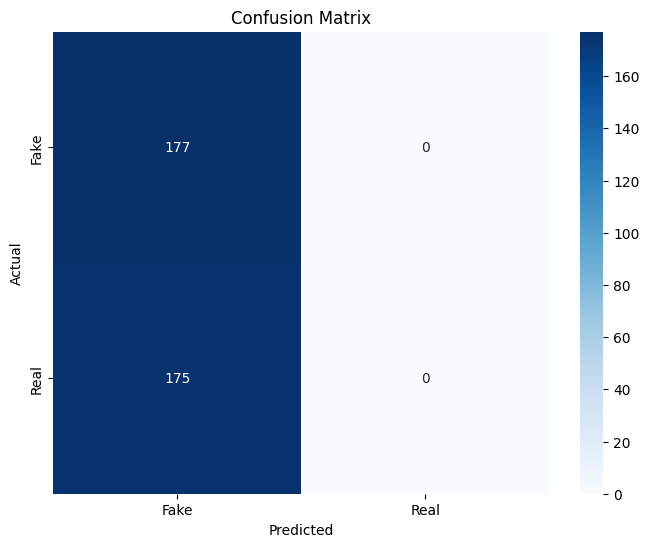

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize empty lists to store predictions and true labels
y_true = []
y_pred_classes = []

# Set steps correctly based on the length of the test data and batch size
steps = len(test_gen)



# Predict and accumulate results
for batch_images, batch_labels in test_gen:
    # Stop if we have processed all the steps we need
    if len(y_true) >= steps:
        break

    # Predict the current batch of images
    batch_pred = new_model.predict(batch_images)

    # Convert predictions to class labels (0 or 1)
    batch_pred_classes = np.argmax(batch_pred, axis=1)

    # Append the true labels and predicted labels for the current batch
    y_true.extend(batch_labels)  # Add true labels for this batch
    y_pred_classes.extend(batch_pred_classes)  # Add predicted labels for this batch

# After prediction loop, both y_true and y_pred_classes will contain the full set of labels
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

# Print classification report
print(classification_report(y_true, y_pred_classes))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


performance code

In [ ]:
# Freeze all layers in the pre-trained model
for layer in model.layers:
    layer.trainable = False

# Add new layers on top of the pre-trained model if necessary
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

# Add custom layers
x = Flatten()(model.output)  # Flatten the output of the base model
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create the new model with the base and custom layers
new_model = Model(inputs=model.input, outputs=x)

# Compile the model
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the updated model
new_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,687,298 (97.99 MB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 25,686,913 (97.99 MB)

PERFORMANCE METRICS


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming that X_test and y_test are already defined and preprocessed
# If not, use a proper data loading mechanism as shown in earlier steps

# Create an ImageDataGenerator instance for the test set (without data augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize the images to [0, 1]

# Create the test generator (assuming you have X_test and y_test)
test_gen = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Evaluate on the test set
test_loss, test_acc = new_model.evaluate(test_gen, steps=len(X_test) // 32)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

# Predictions
y_pred = new_model.predict(test_gen, steps=len(X_test) // 32)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report and Confusion Matrix
print(classification_report(y_test, y_pred_classes))
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()



NameError: name 'X_test' is not defined

fine-tuning the pretrained model

training the model

In [ ]:
# Initialize the ImageDataGenerator for training
train_gen = ImageDataGenerator(X_train, y_train, batch_size=32)

# Train the model (fine-tuning)
history = new_model.fit(train_gen, epochs=10, steps_per_epoch=len(X_train) // 32)



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


AttributeError: 'NoneType' object has no attribute 'items'

evaluate the model

NameError: name 'history' is not defined

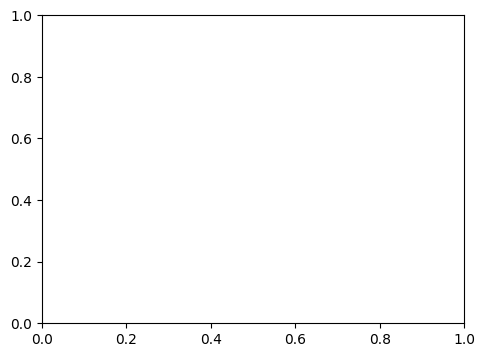

In [ ]:
import matplotlib.pyplot as plt

# Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test data (if test data exists)
test_data = pd.read_csv('/content/test_data.csv')  # Assuming you have test data in a CSV
X_test = test_data['file_path'].values
y_test = test_data['label'].values

test_gen = ImageDataGenerator(X_test, y_test, batch_size=32)
test_loss, test_accuracy = new_model.evaluate(test_gen)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')


confusion matrix and classification report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions on test data
y_pred = new_model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred_classes)
print(report)


saving the fine-tuned model

In [ ]:
# Save the fine-tuned model
fine_tuned_model_path = '/content/drive/MyDrive/fine_tuned_model.h5'
new_model.save(fine_tuned_model_path)


In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have 'history' object from model training, which contains the accuracy values
# history = new_model.fit(...)

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()


NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

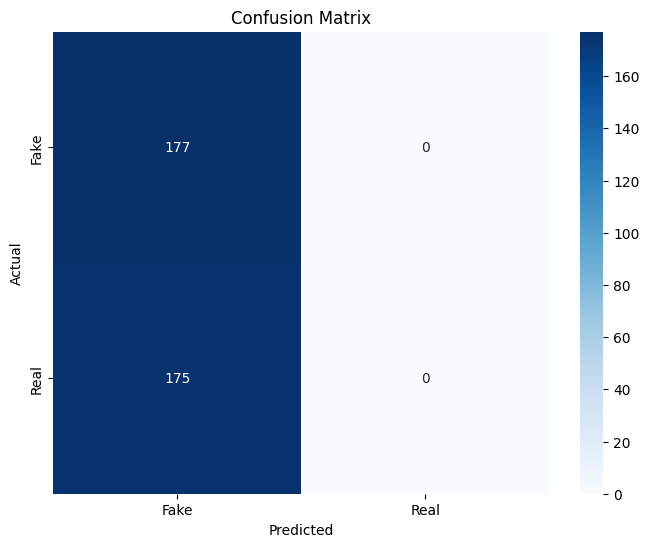

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assume 'y_true' and 'y_pred_classes' are already defined.
# y_true should be the true labels (e.g., y_test) and y_pred_classes the predicted class labels.
# y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Assuming you have already defined your model as 'new_model' and your training data is ready
# For example:
# X_train, y_train  # Preprocessed training data

# Example: Train the model and store the history
history = new_model.fit(X_train, y_train,
                        epochs=5,  # Number of epochs
                        batch_size=32,  # Batch size
                        validation_data=(X_val, y_val),  # Validation data (optional)
                        verbose=1)  # Verbosity level


Epoch 1/5


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_1/Cast:0", shape=(None,), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (None,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None,), dtype=string)
  • training=True
  • mask=None

In [ ]:
# Predict the probabilities for the test data
y_pred_probs = new_model.predict(X_test)  # Predict the probabilities for each class

# If the model has multiple classes (e.g., binary classification), select the positive class probabilities
if y_pred_probs.shape[1] > 1:
    y_pred_probs = y_pred_probs[:, 1]  # Assuming class 1 is the positive class

# Print the predicted probabilities
print(y_pred_probs)


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_1/Cast:0", shape=(32,), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (32,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32,), dtype=string)
  • training=False
  • mask=None

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image size for your model (224, 224 for VGG16)
image_size = (224, 224)

# Initialize the ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    preprocessing_function=preprocess_input,  # Apply VGG16-specific preprocessing
)

# Create a data generator for the training set
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/Dataset 2/train',  # Path to the training directory
    target_size=image_size,  # Resize images to the target size
    batch_size=32,  # Set the batch size
    class_mode='binary',  # Set to 'binary' for binary classification (Fake vs Real)
    shuffle=True  # Shuffle the data for randomness
)

# Define the validation data generator in the same way (optional, but recommended)
val_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    preprocessing_function=preprocess_input,  # Apply VGG16-specific preprocessing
)

val_generator = val_datagen.flow_from_directory(
    '/content/dataset/Dataset 2/val',  # Path to the validation directory
    target_size=image_size,  # Resize images to the target size
    batch_size=32,  # Set the batch size
    class_mode='binary',  # Set to 'binary' for binary classification (Fake vs Real)
    shuffle=True  # Shuffle the validation data for randomness
)



NameError: name 'preprocess_input' is not defined

In [ ]:
# Train the model using the train and validation generators
history = new_model.fit(
    train_generator,
    epochs=5,  # Number of epochs
    validation_data=val_generator,  # Validation data generator
    verbose=1  # Verbosity level
)

